## DNN to Model Stock Prices

This notebook contains the code to both train and use DNN based models for stock price prediction. If you have the .h5 file for a given stock present in the same directory as this notebook there is no need to execute the cells with the comment `# RUN THIS CELL ONCE, SUBSEQUENT EXECUTIONS WILL RETRAIN THE MODEL` and you can immediately run the cells below.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import numpy as np

start_date = '2015-01-01'
end_date = '2020-12-18'

### Download and Pre-Process Pricing Data

In [2]:
def get_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Average'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4
    data['Returns'] = np.log(data['Average'] / data['Average'].shift(1))
    data['Returns'].fillna(0, inplace=True)
    data.drop(["Adj Close"], axis=1, inplace=True)
    return data

def preprocess_data(data, scaler):
    scaled_data = scaler.transform(data)
    X_train = []
    y_train = []
    for i in range(42, len(scaled_data) - 14):
        X_train.append(scaled_data[i-42:i])
        y_train.append(scaled_data[i:i+14, data.columns.get_loc('Close')])  # Assuming 'Close' is the column to predict
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], 42, X_train.shape[2]))  # Reshape for LSTM Model
    return X_train, y_train

### Create, Train, Save and Load Model

In [3]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=14, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=21, return_sequences=False))
    model.add(Dense(units=14))  # Output layer predicts the closing price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(model, X_train, y_train, batch_size=32, epochs=30):
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    return model

def save_model(model, model_name):
    model.save(model_name)

def load_saved_model(model_name):
    model = load_model(model_name)
    # print("Model loaded successfully")
    return model

### Make and Plot Predictions

In [4]:
def predict_next_14_days(model, last_42_days):
    last_42_days = last_42_days.reshape((1, 42, 7))
    predicted_prices = model.predict(last_42_days)
    return predicted_prices

def invert_predictions(predictions, scaler, data):
    predicted_prices_placeholder = np.zeros((predictions.shape[1], data.shape[1]))
    predicted_prices_placeholder[:, data.columns.get_loc('Close')] = predictions[0]
    inverted_predictions = scaler.inverse_transform(predicted_prices_placeholder)
    predicted_closing_prices = inverted_predictions[:, data.columns.get_loc('Close')]
    return predicted_closing_prices

def plot_predictions(actual_prices, predicted_prices):
    fig, ax = plt.subplots()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.suptitle('Predicted Price vs Actual Price', fontsize=20)
    plt.title('Mean Squared Error (MSE): {}'.format(np.round(np.mean((actual_prices - predicted_prices) ** 2), 2)))
    plt.ylabel('USD Price')
    plt.plot(np.arange(len(actual_prices)), actual_prices)
    plt.plot(np.arange(len(predicted_prices)), predicted_prices)
    plt.legend(['Real Price', 'Predicted Price'],
                loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
    plt.show()

### Execute Model for given Stock

In [5]:
def run_model_for_ticker(ticker, relevant_data, relevant_scaler):
    model = load_model(f'{ticker}.h5')
    last_42_days = get_data(ticker, '2020-09-30', '2020-11-30')
    next_14_days = get_data(ticker, '2020-12-01', '2020-12-19')
    last_42_days = relevant_scaler.transform(last_42_days)
    predictions = predict_next_14_days(model, last_42_days)
    predicted_closing_prices = invert_predictions(predictions, relevant_scaler, relevant_data)
    plot_predictions(next_14_days['Close'], predicted_closing_prices)

### AAPL

In [22]:
stock_symbol = 'AAPL'

aapl_data = get_data(stock_symbol, start_date, end_date)
# print(data.head())

aapl_scaler = MinMaxScaler(feature_range=(0, 1))
_ = aapl_scaler.fit_transform(aapl_data)

[*********************100%***********************]  1 of 1 completed


In [27]:
# RUN THIS CELL ONCE, SUBSEQUENT EXECUTIONS WILL RETRAIN THE MODEL

X_train, y_train = preprocess_data(aapl_data, aapl_scaler)
model = build_lstm_model(X_train.shape[1:])
model = train_model(model, X_train, y_train, epochs=15)
save_model(model, 'AAPL.h5')

Epoch 1/15
46/46 [==============================] - 16s 73ms/step - loss: 0.0402
Epoch 2/15
46/46 [==============================] - 3s 73ms/step - loss: 0.0028
Epoch 3/15
46/46 [==============================] - 3s 73ms/step - loss: 0.0015
Epoch 4/15
46/46 [==============================] - 3s 73ms/step - loss: 0.0013
Epoch 5/15
46/46 [==============================] - 3s 72ms/step - loss: 0.0012
Epoch 6/15
46/46 [==============================] - 3s 73ms/step - loss: 0.0011
Epoch 7/15
46/46 [==============================] - 3s 73ms/step - loss: 0.0011
Epoch 8/15
46/46 [==============================] - 3s 72ms/step - loss: 0.0011
Epoch 9/15
46/46 [==============================] - 3s 73ms/step - loss: 0.0011
Epoch 10/15
46/46 [==============================] - 3s 73ms/step - loss: 9.8283e-04
Epoch 11/15
46/46 [==============================] - 3s 73ms/step - loss: 9.8577e-04
Epoch 12/15
46/46 [==============================] - 3s 73ms/step - loss: 9.5114e-04
Epoch 13/15
46/46 [=====

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 3s 3s/step


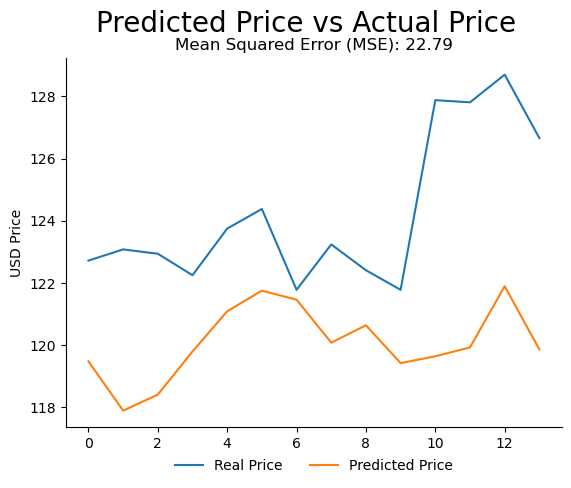

In [29]:
run_model_for_ticker('AAPL', aapl_data, aapl_scaler)

### GOOG

In [19]:
stock_symbol = 'GOOG'

goog_data = get_data(stock_symbol, start_date, end_date)
# print(data.head())

goog_scaler = MinMaxScaler(feature_range=(0, 1))
_ = goog_scaler.fit_transform(goog_data)

[*********************100%***********************]  1 of 1 completed


In [30]:
# RUN THIS CELL ONCE, SUBSEQUENT EXECUTIONS WILL RETRAIN THE MODEL

X_train, y_train = preprocess_data(goog_data, goog_scaler)
model = build_lstm_model(X_train.shape[1:])
model = train_model(model, X_train, y_train, epochs=20)
save_model(model, 'GOOG.h5')

Epoch 1/20
46/46 [==============================] - 16s 75ms/step - loss: 0.0731
Epoch 2/20
46/46 [==============================] - 3s 73ms/step - loss: 0.0057
Epoch 3/20
46/46 [==============================] - 3s 73ms/step - loss: 0.0031
Epoch 4/20
46/46 [==============================] - 3s 73ms/step - loss: 0.0026
Epoch 5/20
46/46 [==============================] - 3s 74ms/step - loss: 0.0025
Epoch 6/20
46/46 [==============================] - 3s 73ms/step - loss: 0.0023
Epoch 7/20
46/46 [==============================] - 3s 73ms/step - loss: 0.0022
Epoch 8/20
46/46 [==============================] - 3s 74ms/step - loss: 0.0021
Epoch 9/20
46/46 [==============================] - 3s 73ms/step - loss: 0.0021
Epoch 10/20
46/46 [==============================] - 3s 73ms/step - loss: 0.0020
Epoch 11/20
46/46 [==============================] - 3s 73ms/step - loss: 0.0019
Epoch 12/20
46/46 [==============================] - 3s 73ms/step - loss: 0.0019
Epoch 13/20
46/46 [=================

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 3s 3s/step


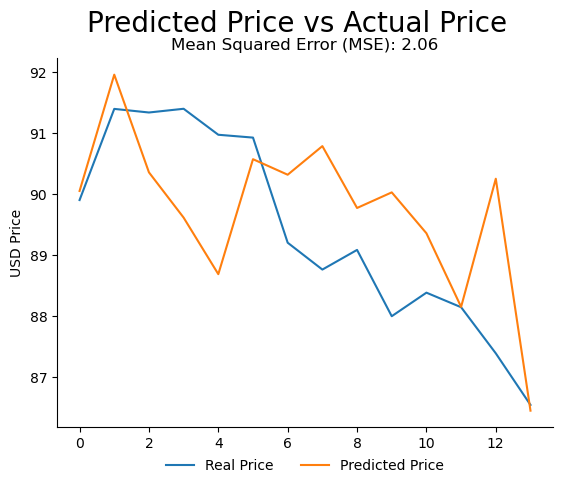

In [31]:
run_model_for_ticker('GOOG', goog_data, goog_scaler)

### MSFT

In [34]:
stock_symbol = 'MSFT'

msft_data = get_data(stock_symbol, start_date, end_date)
# print(data.head())

msft_scaler = MinMaxScaler(feature_range=(0, 1))
_ = msft_scaler.fit_transform(msft_data)

[*********************100%***********************]  1 of 1 completed


In [35]:
# RUN THIS CELL ONCE, SUBSEQUENT EXECUTIONS WILL RETRAIN THE MODEL

X_train, y_train = preprocess_data(msft_data, msft_scaler)
model = build_lstm_model(X_train.shape[1:])
model = train_model(model, X_train, y_train, epochs=15)
save_model(model, 'MSFT.h5')

Epoch 1/15
46/46 [==============================] - 15s 73ms/step - loss: 0.0901
Epoch 2/15
46/46 [==============================] - 3s 73ms/step - loss: 0.0062
Epoch 3/15
46/46 [==============================] - 3s 73ms/step - loss: 0.0016
Epoch 4/15
46/46 [==============================] - 3s 72ms/step - loss: 0.0012
Epoch 5/15
46/46 [==============================] - 3s 72ms/step - loss: 0.0010
Epoch 6/15
46/46 [==============================] - 3s 73ms/step - loss: 9.6929e-04
Epoch 7/15
46/46 [==============================] - 3s 73ms/step - loss: 0.0011
Epoch 8/15
46/46 [==============================] - 3s 73ms/step - loss: 8.6333e-04
Epoch 9/15
46/46 [==============================] - 3s 73ms/step - loss: 8.2198e-04
Epoch 10/15
46/46 [==============================] - 3s 71ms/step - loss: 8.7052e-04
Epoch 11/15
46/46 [==============================] - 3s 73ms/step - loss: 8.0195e-04
Epoch 12/15
46/46 [==============================] - 3s 73ms/step - loss: 8.4327e-04
Epoch 13/15


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 3s 3s/step


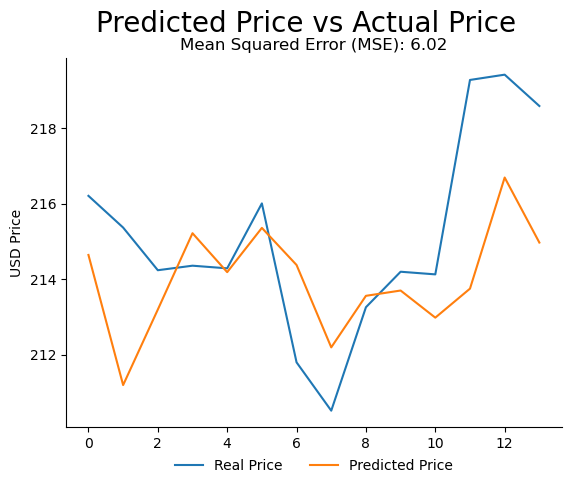

In [36]:
run_model_for_ticker('MSFT', msft_data, msft_scaler)

### TSLA

In [16]:
stock_symbol = 'TSLA'

tsla_data = get_data(stock_symbol, start_date, end_date)
# print(data.head())

tsla_scaler = MinMaxScaler(feature_range=(0, 1))
_ = tsla_scaler.fit_transform(tsla_data)

[*********************100%***********************]  1 of 1 completed


In [17]:
# RUN THIS CELL ONCE, SUBSEQUENT EXECUTIONS WILL RETRAIN THE MODEL

X_train, y_train = preprocess_data(tsla_data, tsla_scaler)
model = build_lstm_model(X_train.shape[1:])
model = train_model(model, X_train, y_train, epochs=30)
save_model(model, 'TSLA.h5')

Epoch 1/30
46/46 [==============================] - 15s 72ms/step - loss: 0.0161
Epoch 2/30
46/46 [==============================] - 3s 72ms/step - loss: 0.0017
Epoch 3/30
46/46 [==============================] - 3s 73ms/step - loss: 0.0011
Epoch 4/30
46/46 [==============================] - 3s 72ms/step - loss: 0.0011
Epoch 5/30
46/46 [==============================] - 3s 73ms/step - loss: 0.0011
Epoch 6/30
46/46 [==============================] - 3s 72ms/step - loss: 0.0010
Epoch 7/30
46/46 [==============================] - 3s 72ms/step - loss: 9.8334e-04
Epoch 8/30
46/46 [==============================] - 3s 73ms/step - loss: 9.7238e-04
Epoch 9/30
46/46 [==============================] - 3s 73ms/step - loss: 9.2904e-04
Epoch 10/30
46/46 [==============================] - 3s 73ms/step - loss: 8.7489e-04
Epoch 11/30
46/46 [==============================] - 3s 72ms/step - loss: 8.5584e-04
Epoch 12/30
46/46 [==============================] - 3s 73ms/step - loss: 8.6912e-04
Epoch 13/30


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 2s 2s/step


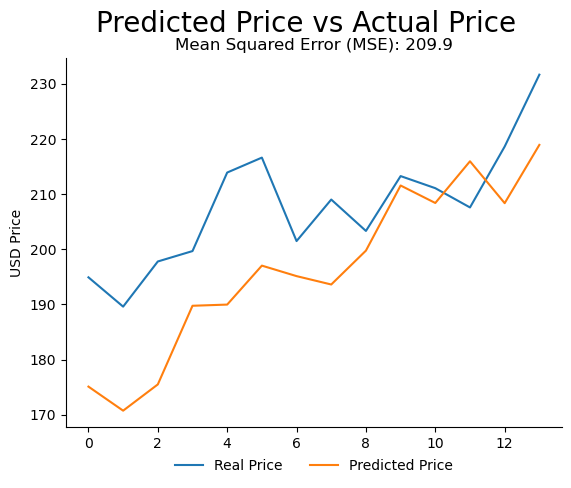

In [18]:
run_model_for_ticker('TSLA', msft_data, tsla_scaler)